##Importing necessary Libraries

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
%matplotlib inline

import seaborn as sns
from sklearn.model_selection  import train_test_split
from sklearn.cluster import KMeans

from scipy.stats import zscore
from scipy.stats import mode
import sklearn.metrics

In [4]:
import geopandas as gpd
from shapely.geometry import Point

In [5]:
import seaborn as sns

## Loading Dataset from Google Drive

In [6]:
from google.colab import drive
drive.mount('gdrive')
%cd gdrive/My Drive/Clustering/Clustering with PyCaret - Case Study - USU/

Mounted at gdrive
/content/gdrive/My Drive/Clustering/Clustering with PyCaret - Case Study - USU


In [7]:
df = pd.read_csv("motor_vech_crashes.csv")

<ipython-input-7-7172afe9de1d>:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("motor_vech_crashes.csv")


## Data Overview

In [8]:
df.shape

(2130612, 29)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2130612 entries, 0 to 2130611
Data columns (total 29 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   crash_date                  object 
 1   crash_time                  object 
 2   borough                     object 
 3   zipcode                     object 
 4   latitude                    float64
 5   longitude                   float64
 6   location                    object 
 7   on_street_name              object 
 8   cross_street_name           object 
 9   off_street_name             object 
 10  no_of_persons_injured       float64
 11  no_of_persons_killed        float64
 12  no_of_pedestrians_injured   int64  
 13  no_of_perdestrians_killed   int64  
 14  no_of_cyclist_injured       int64  
 15  no_of_cyclist_killed        int64  
 16  no_of_motorist_injured      int64  
 17  no_of_motorist_killed       int64  
 18  contributing_factor_vech_1  object 
 19  contributing_factor_v

In [10]:
df.head(5)

,crash_date,crash_time,borough,zipcode,latitude,longitude,location,on_street_name,cross_street_name,off_street_name,...,contributing_factor_vech_2,contributing_factor_vech_3,contributing_factor_vech_4,contributing_factor_vech_5,collission_id,vech_type_code_1,vech_type_code_2,vech_type_code_3,vech_type_code_4,vech_type_code_5
0,09/11/2021,2:39,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4455765,Sedan,Sedan,NaN,NaN,NaN
1,03/26/2022,11:45,NaN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,...,NaN,NaN,NaN,NaN,4513547,Sedan,NaN,NaN,NaN,NaN
2,06/29/2022,6:55,NaN,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4541903,Sedan,Pick-up Truck,NaN,NaN,NaN
3,09/11/2021,9:35,BROOKLYN,11208.0,40.667202,-73.866500,"(40.667202, -73.8665)",NaN,NaN,1211 LORING AVENUE,...,NaN,NaN,NaN,NaN,4456314,Sedan,NaN,NaN,NaN,NaN
4,12/14/2021,8:13,BROOKLYN,11233.0,40.683304,-73.917274,"(40.683304, -73.917274)",SARATOGA AVENUE,DECATUR STREET,NaN,...,NaN,NaN,NaN,NaN,4486609,NaN,NaN,NaN,NaN,NaN


## Exploratory Data Analysis(EDA)

### EDA Functions

In [11]:
def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (15,10))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature,showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
         data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins
     ) if bins else sns.histplot(
         data=data, x=feature, kde=kde, ax=ax_hist2
     )  # For histogram
    ax_hist2.axvline(
         data[feature].mean(), color="green", linestyle="--"
     )  # Add mean to the histogram
    ax_hist2.axvline(
         data[feature].median(), color="black", linestyle="-"
     )  # Add median to the histogram

In [12]:
# function to create labeled barplots


def labeled_barplot_sum(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.sum(
        data=data,
        x=feature,
        hue=feature,
        legend=False,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage


In [13]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        hue=feature,
        legend=False,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage


In [14]:
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

In [15]:
## function to plot distributions wrt target


def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
        stat="density",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
        stat="density",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

In [16]:
#TOP 10 - BAR PLOT
def top_10_bar_plot(df, column_name,display_name):
       # Count occurrences of each value in the column
    value_counts = df[column_name].value_counts().head(10)

    # Plotting the top 10 occurrences with different colors and a bigger size
    plt.figure(figsize=(14, 6))
    bars = value_counts.plot(kind='bar', color=plt.cm.Paired(range(len(value_counts))))

    # Adding totals on top of each bar
    for bar in bars.patches:
        bars.annotate(format(bar.get_height(), '.0f'),
                      (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                      ha='center', va='center', size=12, xytext=(0, 8),
                      textcoords='offset points')

    plt.title(f'Top 10 Occurrences in {display_name}')
    plt.xlabel(display_name)
    plt.ylabel('Frequency')
    plt.show()

In [17]:
def top_10_bar_plot_percent(df, column_name,display_name):
       # Count occurrences of each value in the column
    # Count occurrences of each value in the column
    value_counts = df[column_name].value_counts(normalize=True).head(10) * 100  # Convert to percentage

    # Plotting the top 10 occurrences with different colors and a bigger size
    plt.figure(figsize=(12, 6))
    bars = value_counts.plot(kind='bar', color=plt.cm.Paired(range(len(value_counts))))

    # Adding percentages on top of each bar
    for bar in bars.patches:
        bars.annotate(format(bar.get_height(), '.2f') + '%',
                      (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                      ha='center', va='center', size=12, xytext=(0, 8),
                      textcoords='offset points')

    plt.title(f'Top 10 Occurrences in {display_name}')
    plt.xlabel(display_name)
    plt.ylabel('Percentage')
    plt.show()

In [18]:
df.head()

,crash_date,crash_time,borough,zipcode,latitude,longitude,location,on_street_name,cross_street_name,off_street_name,...,contributing_factor_vech_2,contributing_factor_vech_3,contributing_factor_vech_4,contributing_factor_vech_5,collission_id,vech_type_code_1,vech_type_code_2,vech_type_code_3,vech_type_code_4,vech_type_code_5
0,09/11/2021,2:39,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4455765,Sedan,Sedan,NaN,NaN,NaN
1,03/26/2022,11:45,NaN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,...,NaN,NaN,NaN,NaN,4513547,Sedan,NaN,NaN,NaN,NaN
2,06/29/2022,6:55,NaN,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4541903,Sedan,Pick-up Truck,NaN,NaN,NaN
3,09/11/2021,9:35,BROOKLYN,11208.0,40.667202,-73.866500,"(40.667202, -73.8665)",NaN,NaN,1211 LORING AVENUE,...,NaN,NaN,NaN,NaN,4456314,Sedan,NaN,NaN,NaN,NaN
4,12/14/2021,8:13,BROOKLYN,11233.0,40.683304,-73.917274,"(40.683304, -73.917274)",SARATOGA AVENUE,DECATUR STREET,NaN,...,NaN,NaN,NaN,NaN,4486609,NaN,NaN,NaN,NaN,NaN


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2130612 entries, 0 to 2130611
Data columns (total 29 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   crash_date                  object 
 1   crash_time                  object 
 2   borough                     object 
 3   zipcode                     object 
 4   latitude                    float64
 5   longitude                   float64
 6   location                    object 
 7   on_street_name              object 
 8   cross_street_name           object 
 9   off_street_name             object 
 10  no_of_persons_injured       float64
 11  no_of_persons_killed        float64
 12  no_of_pedestrians_injured   int64  
 13  no_of_perdestrians_killed   int64  
 14  no_of_cyclist_injured       int64  
 15  no_of_cyclist_killed        int64  
 16  no_of_motorist_injured      int64  
 17  no_of_motorist_killed       int64  
 18  contributing_factor_vech_1  object 
 19  contributing_factor_v

In [20]:
df['borough'] = df['borough'].replace({None:'NEW YORK CITY'})
df['latitude'].fillna(0, inplace=True)
df['longitude'].fillna(0, inplace=True)
df['no_of_persons_injured'].fillna(0, inplace=True)
df['no_of_persons_killed'].fillna(0, inplace=True)
df['on_street_name'] = df['on_street_name'].replace({None:'Unknown'})
df['cross_street_name'] = df['cross_street_name'].replace({None:'Unknown'})


<ipython-input-20-f05f513f33f0>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['latitude'].fillna(0, inplace=True)
<ipython-input-20-f05f513f33f0>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.meth

In [21]:
df = df.drop(["zipcode"], axis=1)
df = df.drop(["vech_type_code_5"], axis=1)
#df = df.drop(["collission_id"], axis=1)
df = df.drop(["location"], axis=1)
df = df.drop(["contributing_factor_vech_3"], axis=1)
df = df.drop(["contributing_factor_vech_4"], axis=1)
df = df.drop(["contributing_factor_vech_5"], axis=1)
df = df.drop(["off_street_name"], axis=1)
df = df.drop(["vech_type_code_3"], axis=1)
df = df.drop(["vech_type_code_4"], axis=1)

In [22]:
# Ensure the 'borough' column is of string type (object)
df['borough'] = df['borough'].astype(str)

In [23]:
dataset = df.copy()

In [24]:
dataset.shape

(2130612, 20)

In [25]:
# Extract month and year from the admission date
# Convert 'CLM_ADMSN_DT' to datetime if it's not already
incident_date = pd.to_datetime(dataset['crash_date'])
dataset['Year'] = incident_date.dt.to_period('Y')
dataset['Month'] = incident_date.dt.to_period('M')




In [26]:
dataset['Year'] = dataset['Year'].astype(str)

In [27]:
# Assuming your dataset is a DataFrame named 'dataset' Let us just take 2020-2023 data to do the EDA
dataset = dataset[dataset['Year'].isin(['2020','2021','2022','2023'])]

In [28]:
# Count admissions per month
incidents_per_month = dataset['Month'].value_counts().sort_index()
incidents_per_year = dataset['Year'].value_counts().sort_index()

In [29]:
dataset['no_of_total_affected'] = dataset['no_of_persons_injured'] + dataset['no_of_persons_killed'] + dataset['no_of_cyclist_injured'] + dataset['no_of_cyclist_killed'] + dataset['no_of_motorist_injured'] + dataset['no_of_motorist_killed']

<ipython-input-29-54edddb778dd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['no_of_total_affected'] = dataset['no_of_persons_injured'] + dataset['no_of_persons_killed'] + dataset['no_of_cyclist_injured'] + dataset['no_of_cyclist_killed'] + dataset['no_of_motorist_injured'] + dataset['no_of_motorist_killed']


In [30]:
dataset.shape

(423959, 23)

### Univariate analysis

#### Incidents across all Borough

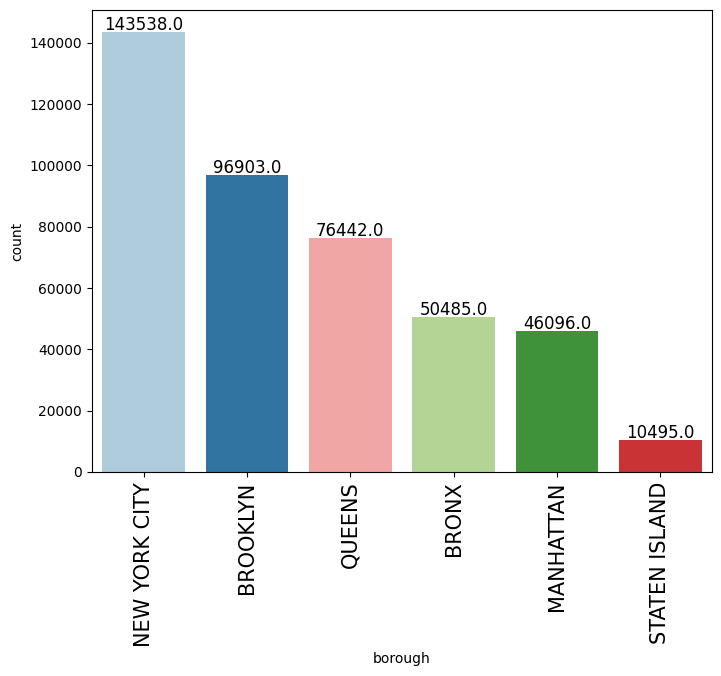

In [31]:
labeled_barplot(dataset, "borough")

**Observation**
* Staten Island has the least number of Incidents.(2020 - 2023)
* I tagged NYC if the Borough was NULL. So NYC tops the list.


#### Top Numbers of total Incidents by Vechile Type

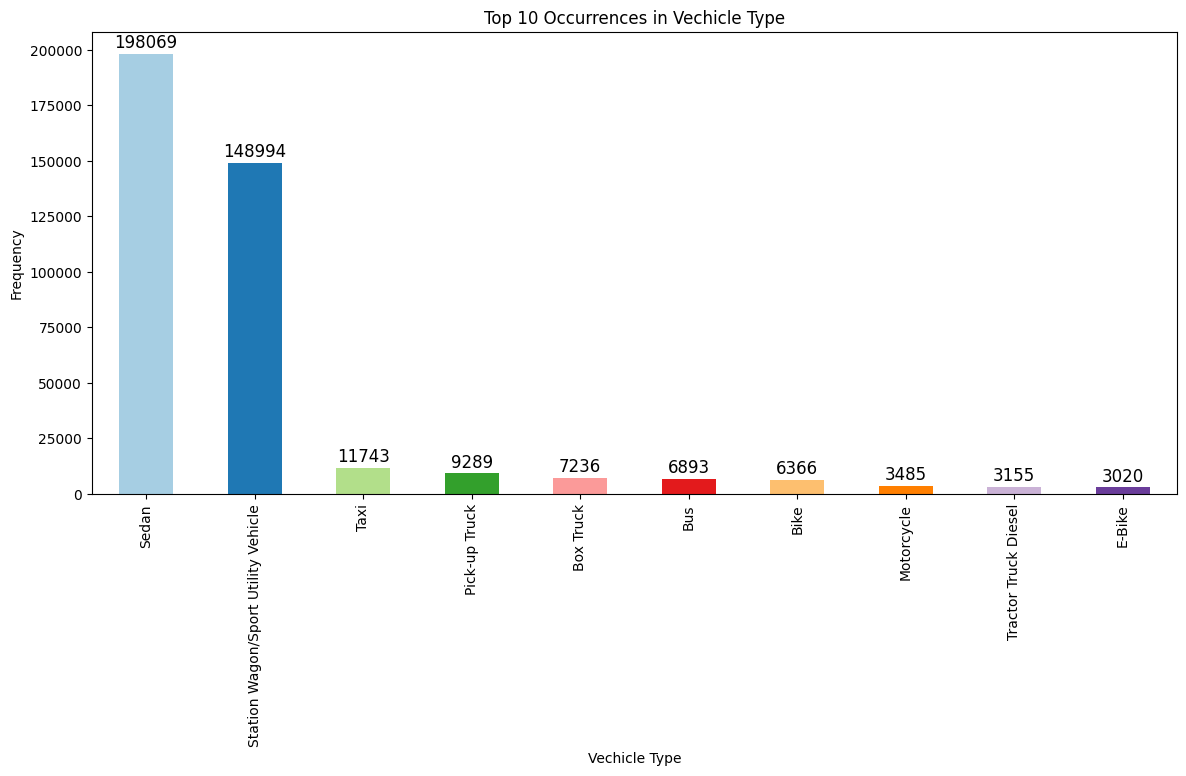

In [32]:
top_10_bar_plot(dataset, "vech_type_code_1","Vechicle Type")

**Observation**
* Sedan has the most incidents followed by SUV.
* E-Bike ranks 10th in this top 10 list.

#### Top Numbers of total Incidents by Contributing Factors

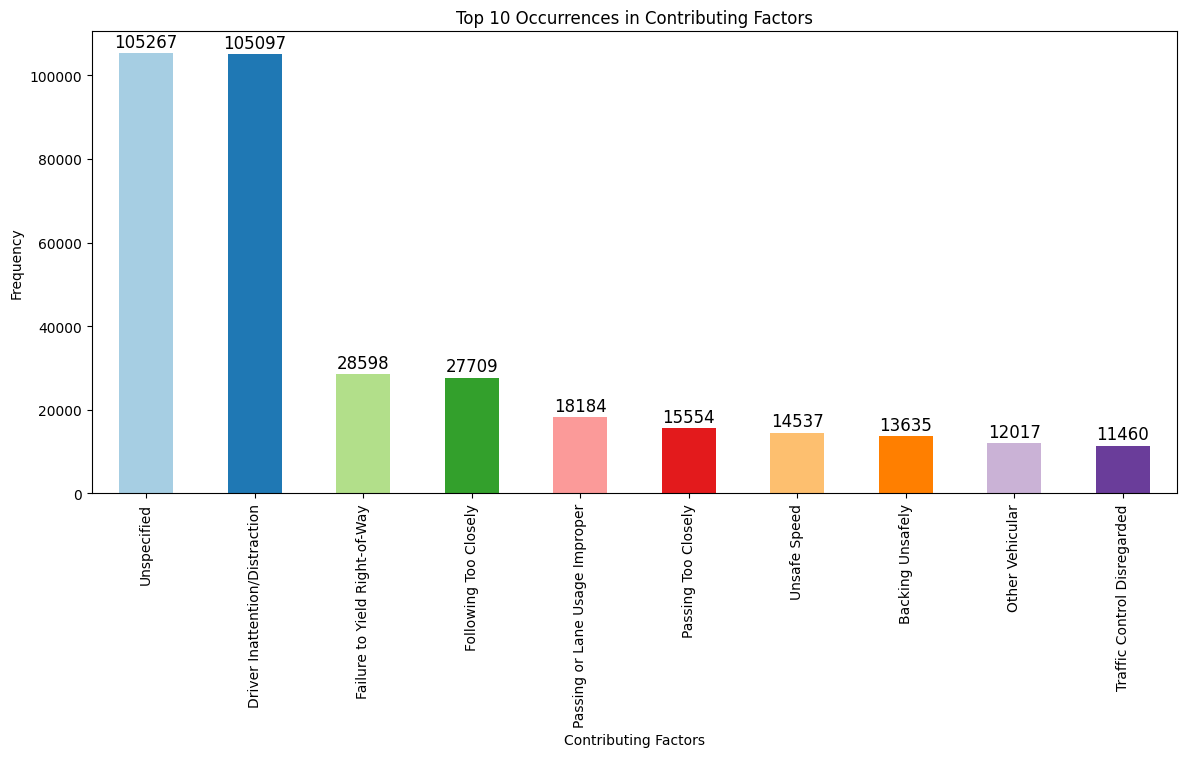

In [33]:
top_10_bar_plot(dataset, "contributing_factor_vech_1","Contributing Factors")


**Observation**

* Top 10 contributors to the accidents across NYC.

#### Top 10 Numbers of total Incidents by Street Names

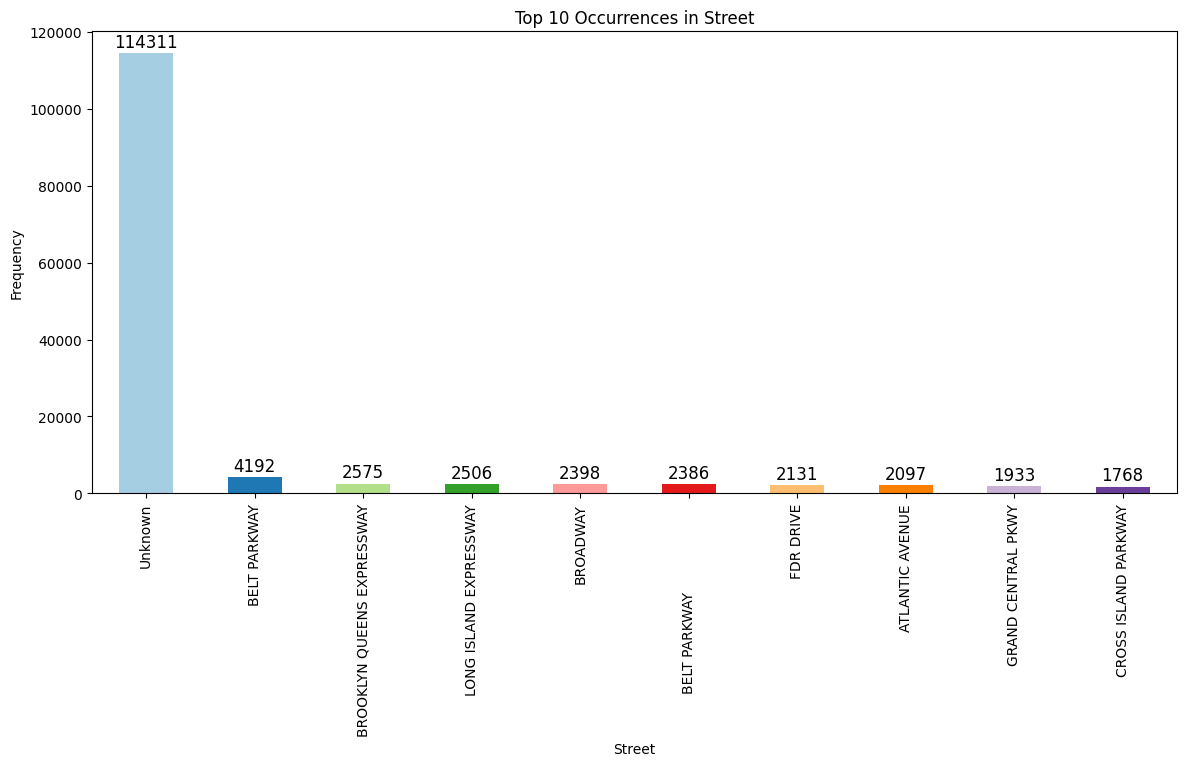

In [34]:
top_10_bar_plot(dataset, "on_street_name","Street")

**Observation**

* There are several unknown locations in this dataset
* Belt Parkway tops the list among the Known Locations

#### Incidents Each Year

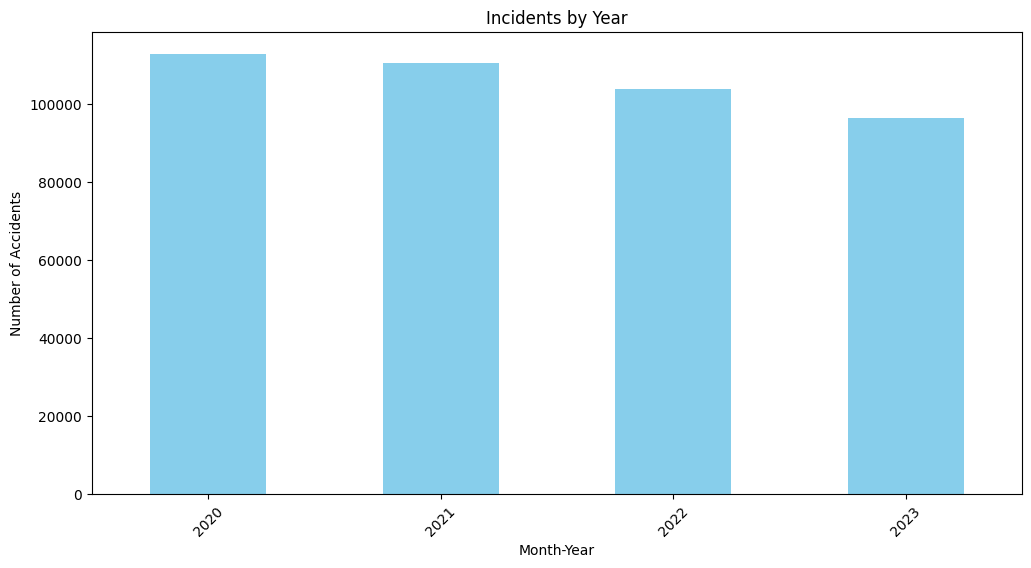

In [35]:
# Plotting the bar plot
plt.figure(figsize=(12, 6))
incidents_per_year.plot(kind='bar', color='skyblue')
plt.title('Incidents by Year')
plt.xlabel('Month-Year')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.show()

#### Top 10 Incidents by Month

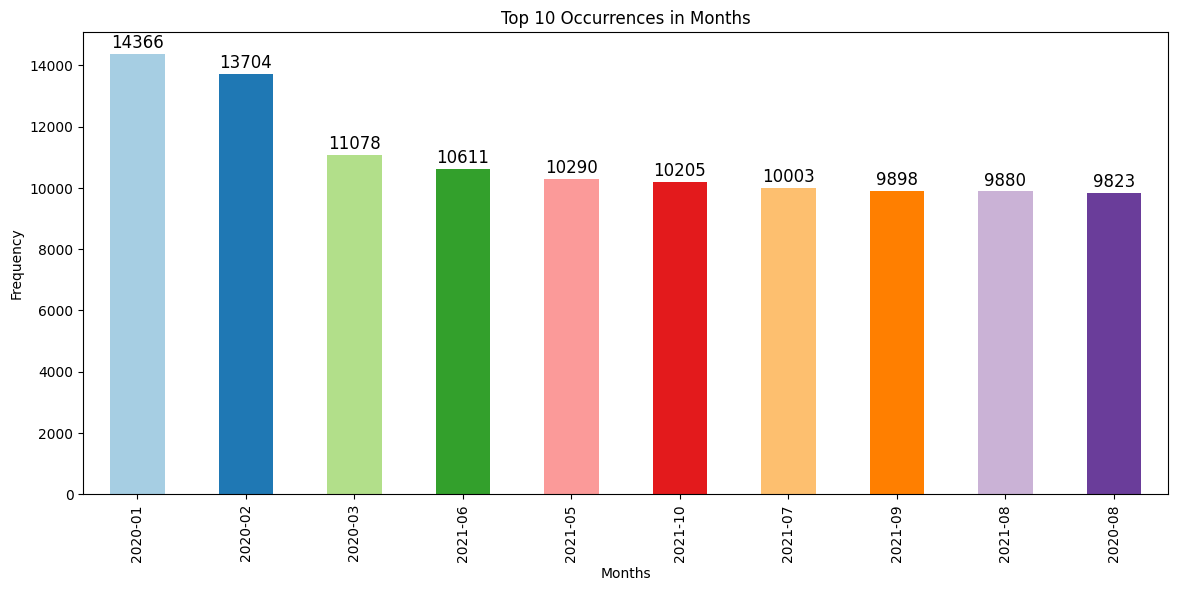

In [36]:
top_10_bar_plot(dataset, "Month","Months")

**Observation**
* Top 10 months having most incidients between 2020 - 2023
* Jan 2020 has the most incidents.

#### NYC Map with Incidents across NYC.

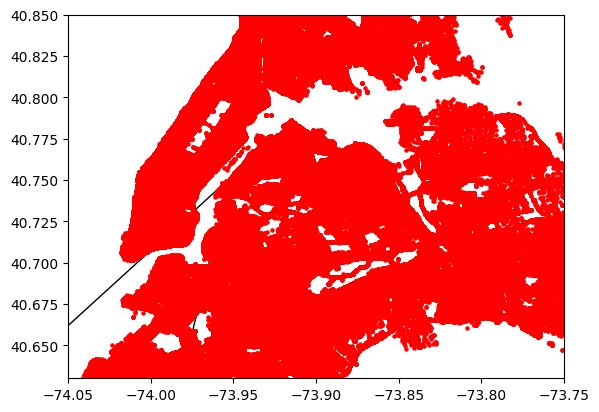

<Figure size 1400x600 with 0 Axes>

In [37]:
# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(dataset, geometry=gpd.points_from_xy(dataset.longitude, dataset.latitude))

# Read a map file
# Load the downloaded shapefile
world = gpd.read_file('ne_110m_admin_0_countries.shp')

# Plot the map
fig, ax = plt.subplots()
world.plot(ax=ax, color='white', edgecolor='black')
gdf.plot(ax=ax, color='red', markersize=5)


# Set limits to zoom in on New York City
ax.set_xlim([-74.05, -73.75])
ax.set_ylim([40.63, 40.85])

# Show the plot
plt.figure(figsize=(14, 6))
plt.show()

**Observation**

* Incidents has happened across NYC in a map.

In [38]:

# Group by 'Year' and 'Category' and sum 'no_of_total_affected'
def total_no_of_incidents_bar_chart(df,col1,col2,hue1,disp1,disp2,title):
  grouped_data = df.groupby([col1, hue1])[col2].sum().reset_index()

# Plotting the results with hue parameter
  plt.figure(figsize=(14, 7))
  bar_plot = sns.barplot(x=col1, y=col2, hue=hue1, data=grouped_data, palette='coolwarm')

# Annotate the bars with the total values
  for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.1f'),
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha = 'center', va = 'center',
                      xytext = (0, 9),
                      textcoords = 'offset points')

  plt.title(title)
  plt.xlabel(col1)
  plt.ylabel(disp1)
  plt.legend(title=hue1, loc='upper left', bbox_to_anchor=(1, 1))
  plt.show()


### Bivariate Analysis

#### Total Incidents By Borough and by Year

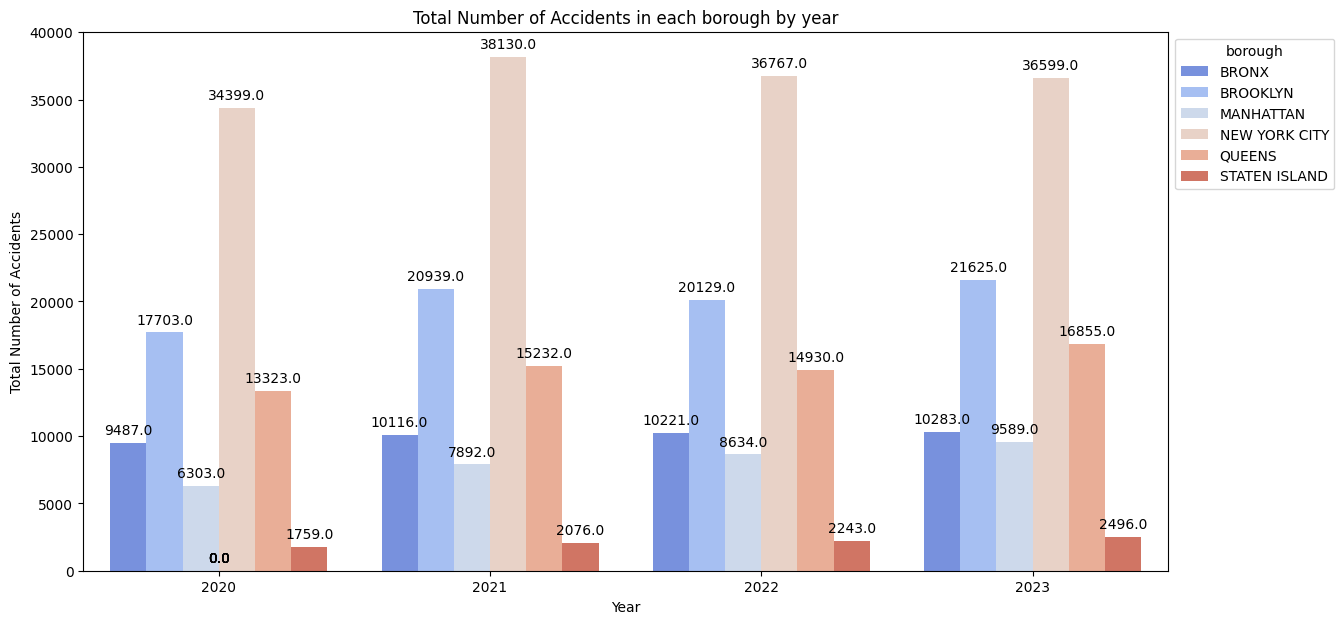

In [39]:
total_no_of_incidents_bar_chart(dataset, "Year", "no_of_total_affected","borough","Total Number of Accidents","Year","Total Number of Accidents in each borough by year")

#### Total numbers of persons killed by borough each year

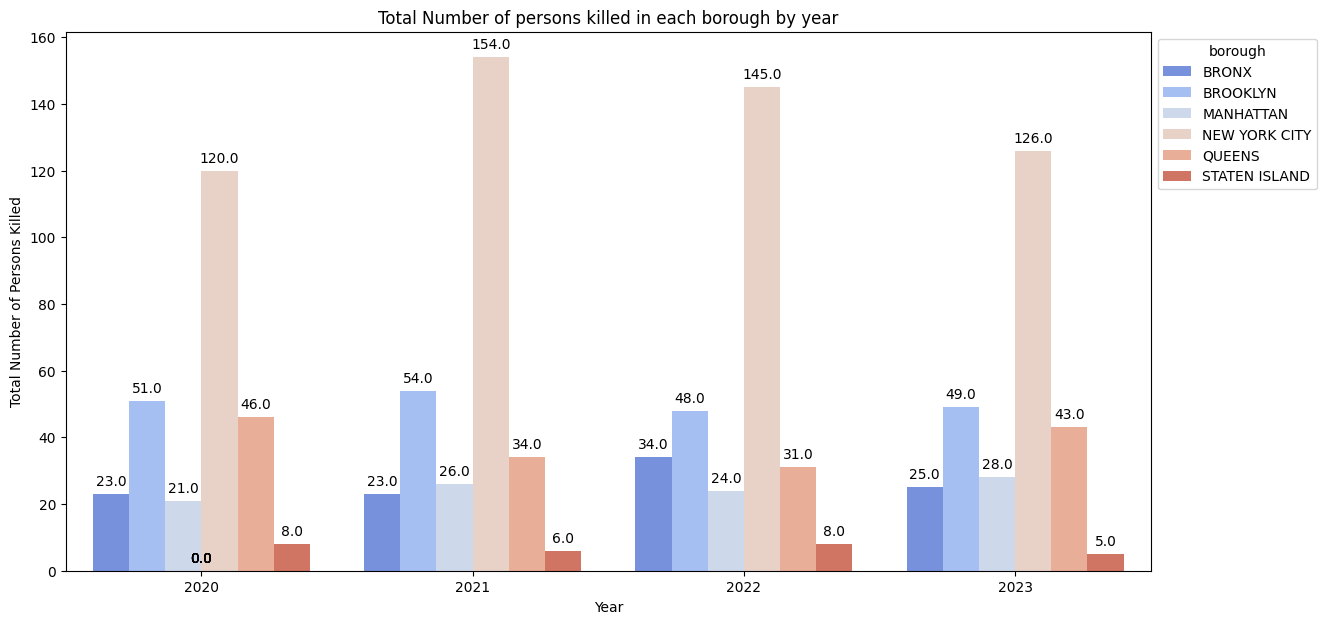

In [40]:
total_no_of_incidents_bar_chart(dataset, "Year", "no_of_persons_killed","borough","Total Number of Persons Killed","Year","Total Number of persons killed in each borough by year")

#### Total numbers of motorist killed by borough each year

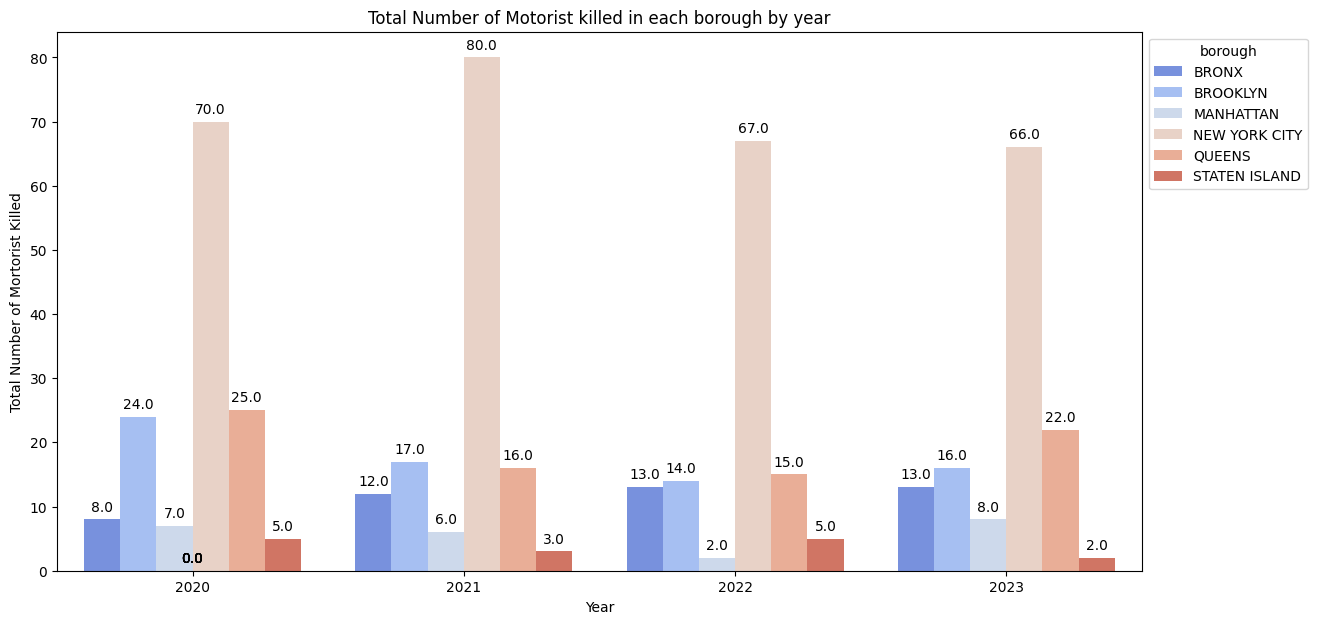

In [41]:
total_no_of_incidents_bar_chart(dataset, "Year", "no_of_motorist_killed","borough","Total Number of Mortorist Killed","Year","Total Number of Motorist killed in each borough by year")

#### Total numbers of pedestrians killed by borough each year

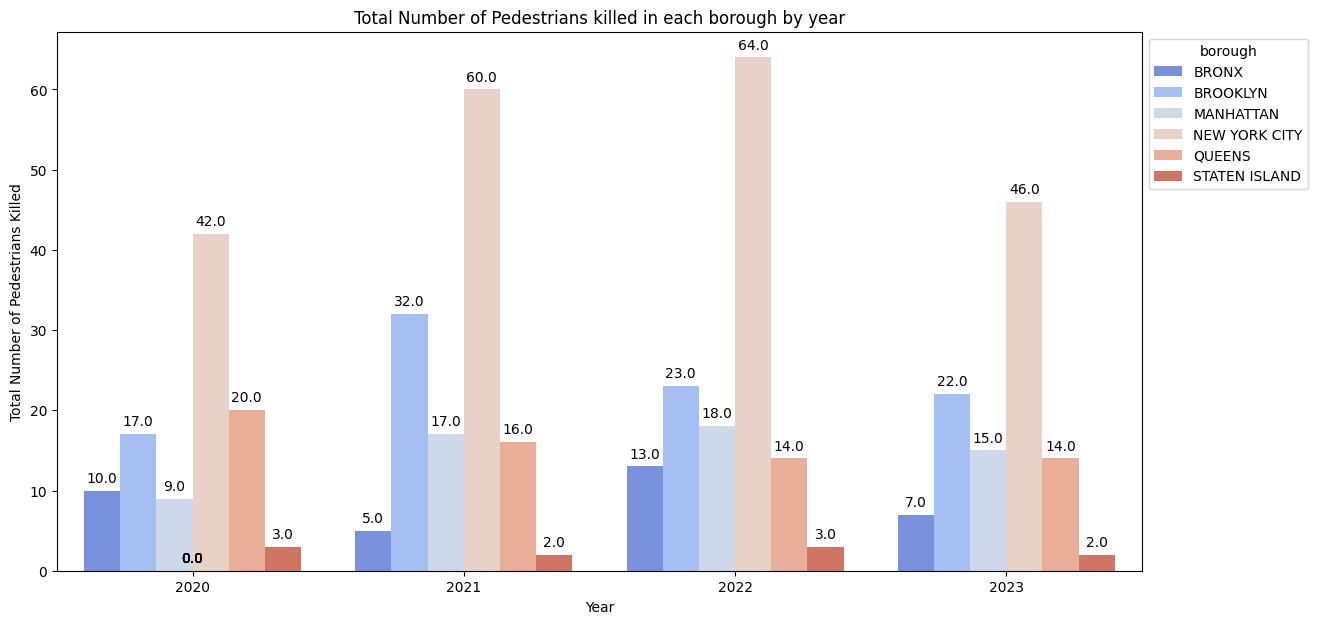

In [42]:
total_no_of_incidents_bar_chart(dataset, "Year", "no_of_perdestrians_killed","borough","Total Number of Pedestrians Killed","Year","Total Number of Pedestrians killed in each borough by year")

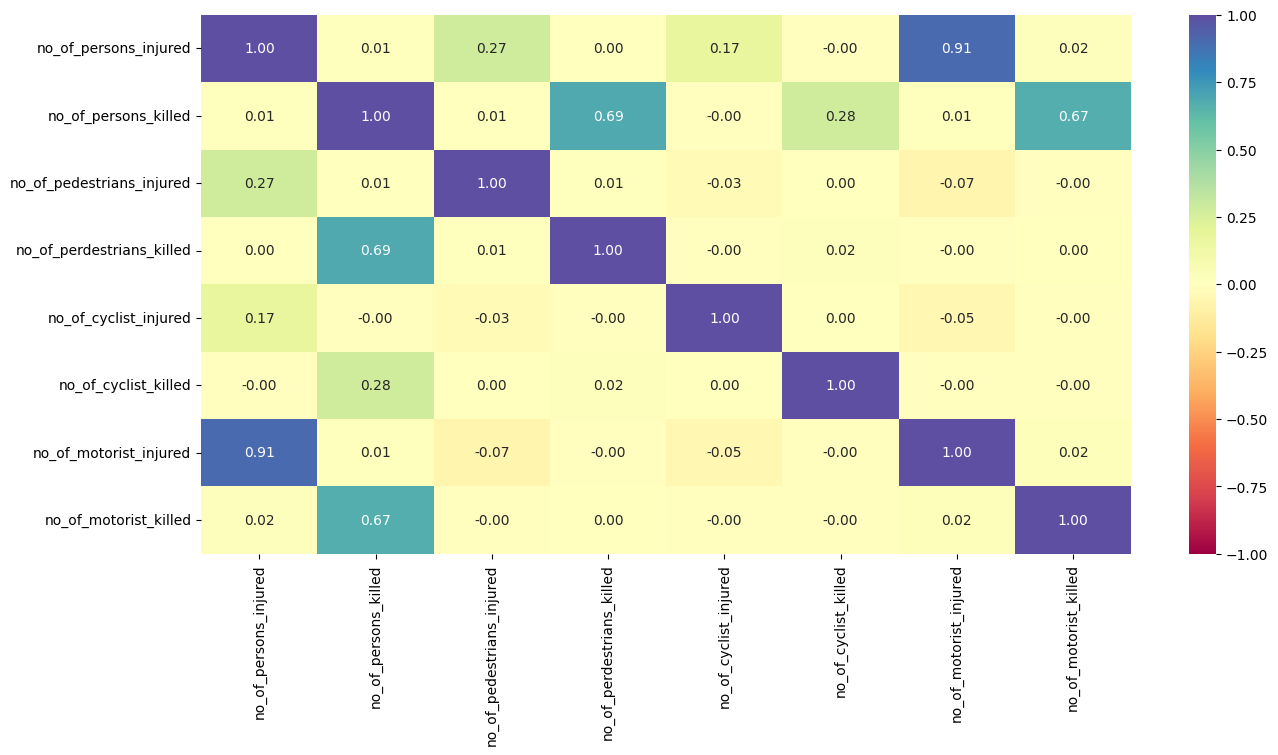

In [43]:
# Check for correlation among numerical variables
num_var = ['no_of_persons_injured','no_of_persons_killed','no_of_pedestrians_injured','no_of_perdestrians_killed','no_of_cyclist_injured', 'no_of_cyclist_killed','no_of_motorist_injured', 'no_of_motorist_killed']

corr = df[num_var].corr()

# plot the heatmap

plt.figure(figsize=(15, 7))
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

**Correlation**
* There is a strong correlation between no_of_motorist_killed and no_of_persons_killed.


In [44]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 423959 entries, 0 to 2129119
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype    
---  ------                      --------------   -----    
 0   crash_date                  423959 non-null  object   
 1   crash_time                  423959 non-null  object   
 2   borough                     423959 non-null  object   
 3   latitude                    423959 non-null  float64  
 4   longitude                   423959 non-null  float64  
 5   on_street_name              423959 non-null  object   
 6   cross_street_name           423959 non-null  object   
 7   no_of_persons_injured       423959 non-null  float64  
 8   no_of_persons_killed        423959 non-null  float64  
 9   no_of_pedestrians_injured   423959 non-null  int64    
 10  no_of_perdestrians_killed   423959 non-null  int64    
 11  no_of_cyclist_injured       423959 non-null  int64    
 12  no_of_cyclist_killed        423959 non-null  int

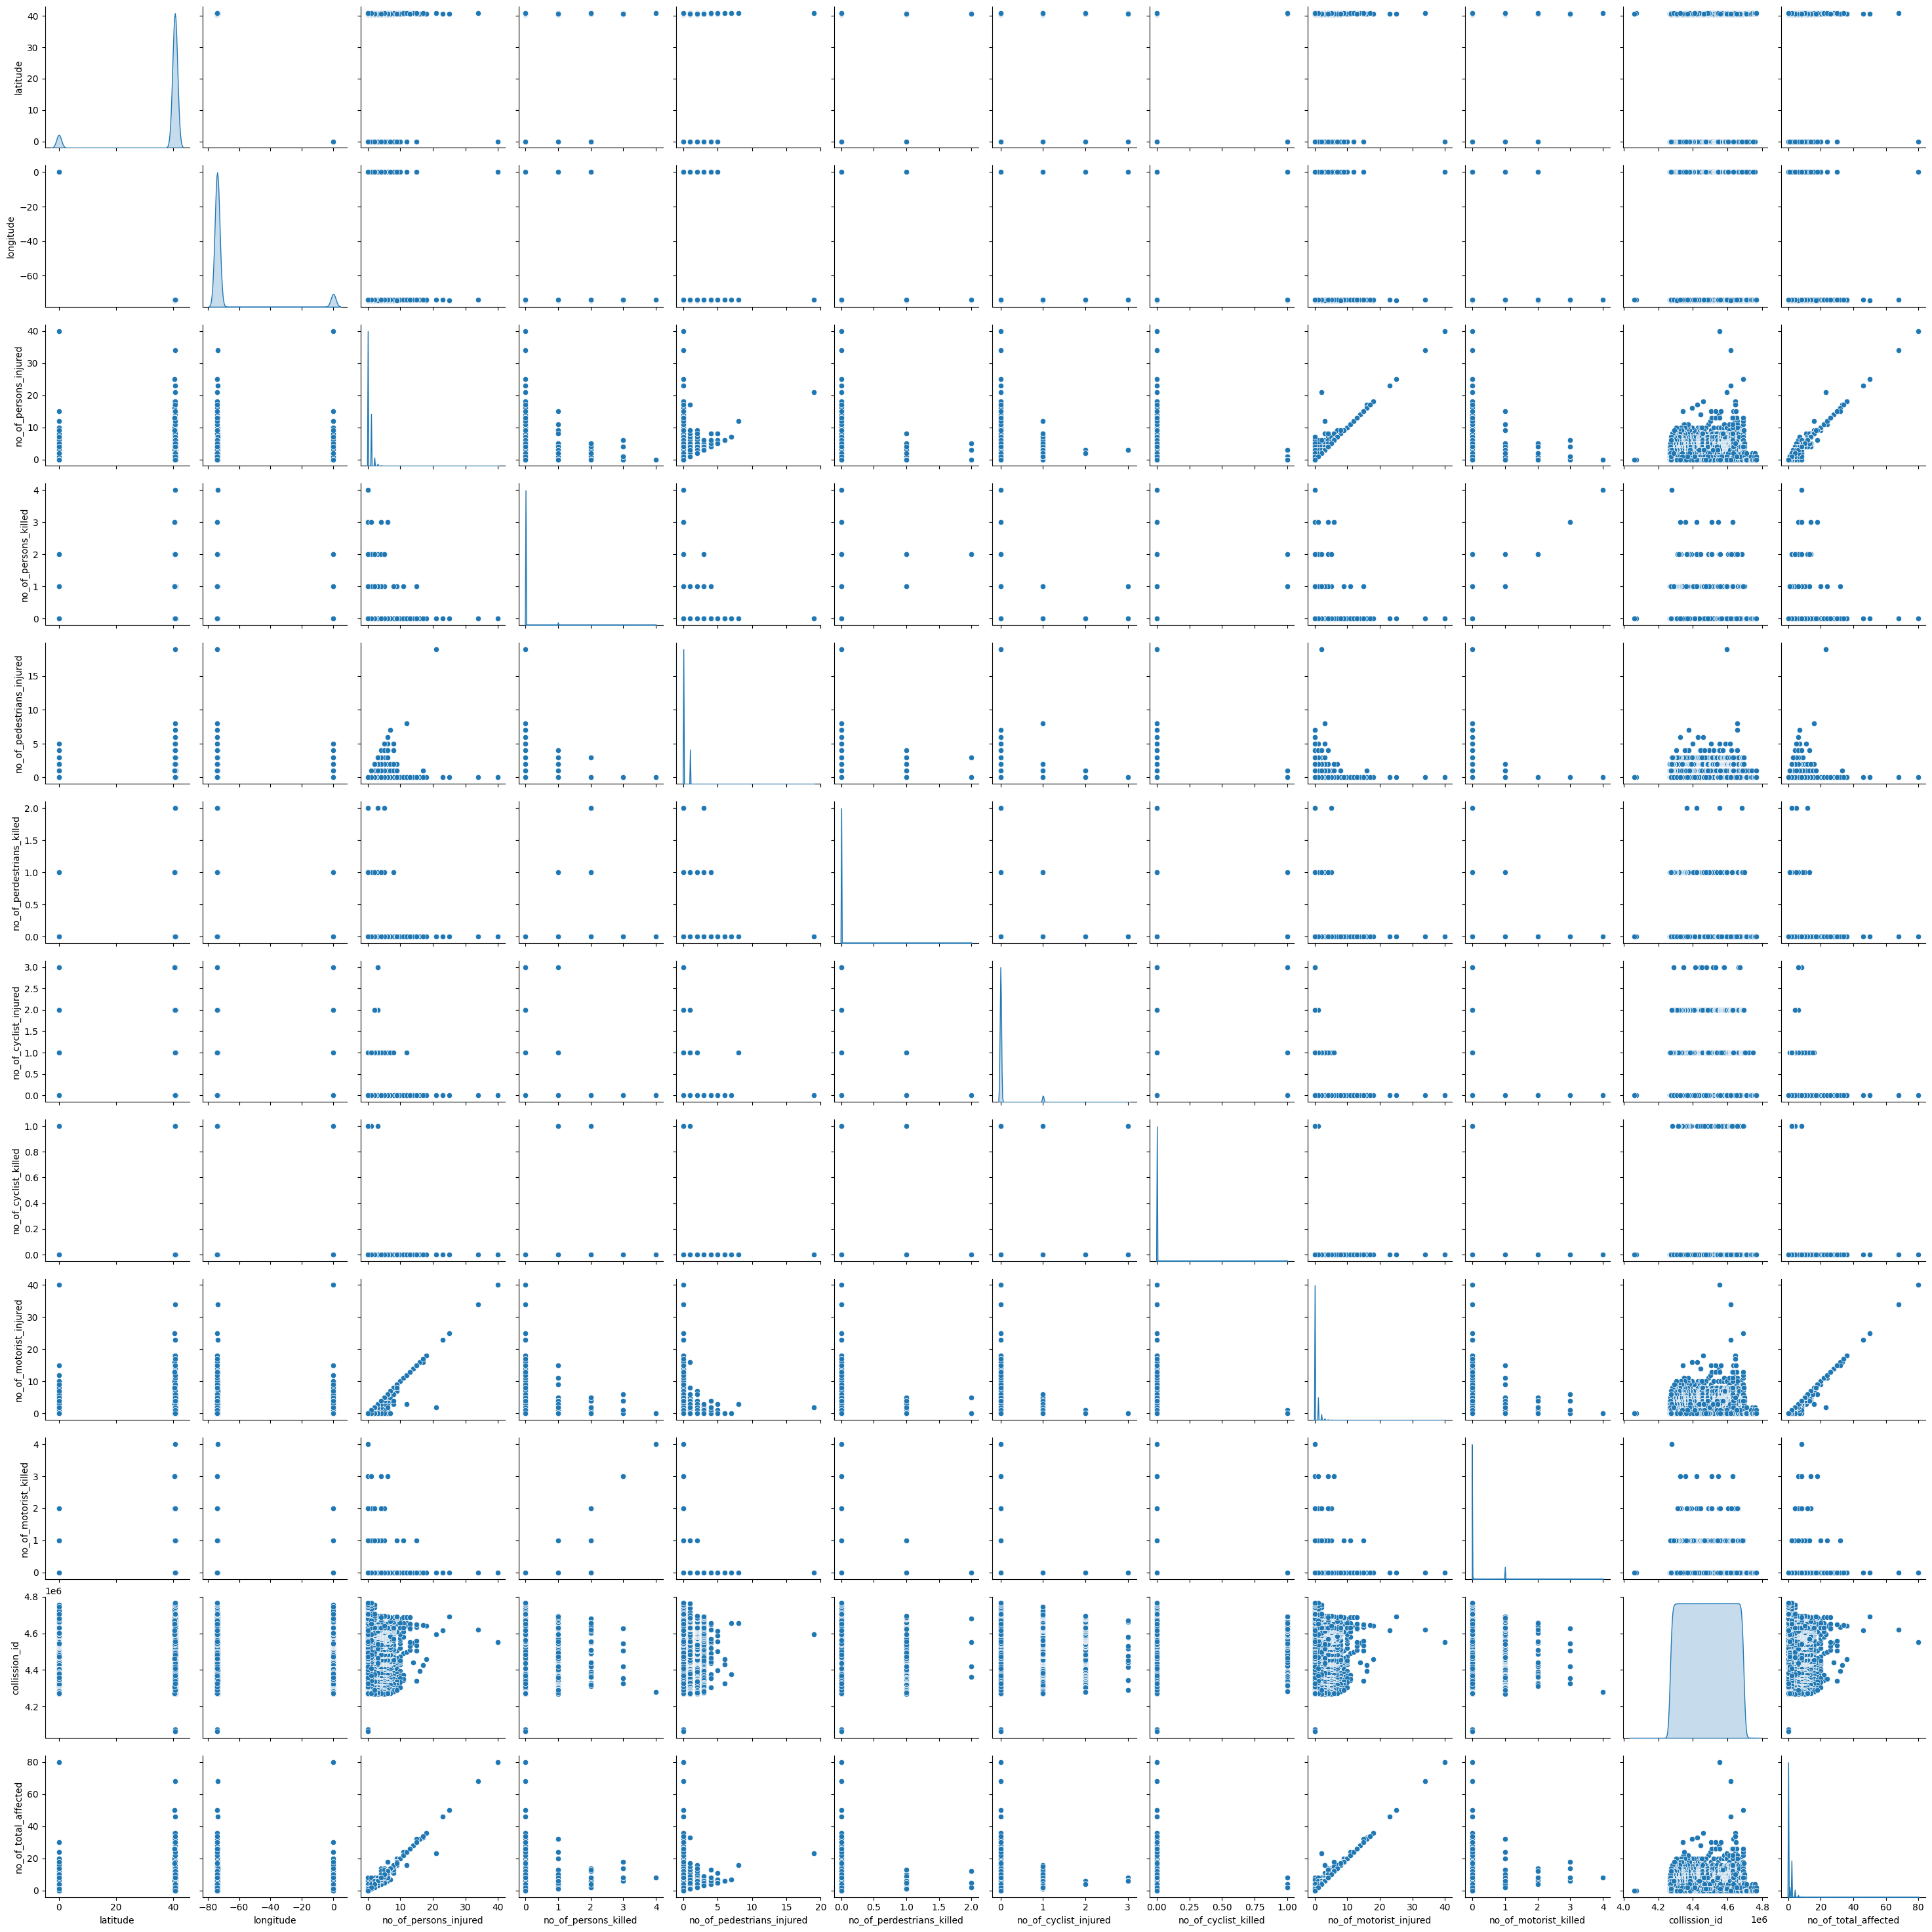

In [45]:
sns.pairplot(data=dataset, diag_kind="kde")
plt.show()

## Data Preprocessing

### Identifies Missing Values

In [46]:
# Finding out the % of missing values in this dataset
# This will help us to determine whether to drop any columns from the dataset.
# COLUMNS OVER 50% MISSING VALUES COULD BE DROPPED IF PROPER IMPUTATION CANNOT BE MADE.
missing_percentage = df.isnull().mean() * 100
print(missing_percentage)


crash_date                     0.000000
crash_time                     0.000000
borough                        0.000000
latitude                       0.000000
longitude                      0.000000
on_street_name                 0.000000
cross_street_name              0.000000
no_of_persons_injured          0.000000
no_of_persons_killed           0.000000
no_of_pedestrians_injured      0.000000
no_of_perdestrians_killed      0.000000
no_of_cyclist_injured          0.000000
no_of_cyclist_killed           0.000000
no_of_motorist_injured         0.000000
no_of_motorist_killed          0.000000
contributing_factor_vech_1     0.336241
contributing_factor_vech_2    15.689248
collission_id                  0.000000
vech_type_code_1               0.682762
vech_type_code_2              19.466426
dtype: float64


In [ ]:
data = df.copy()

### Null Value Treatment

<ipython-input-15-f390878546e4>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")
<ipython-input-15-f390878546e4>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


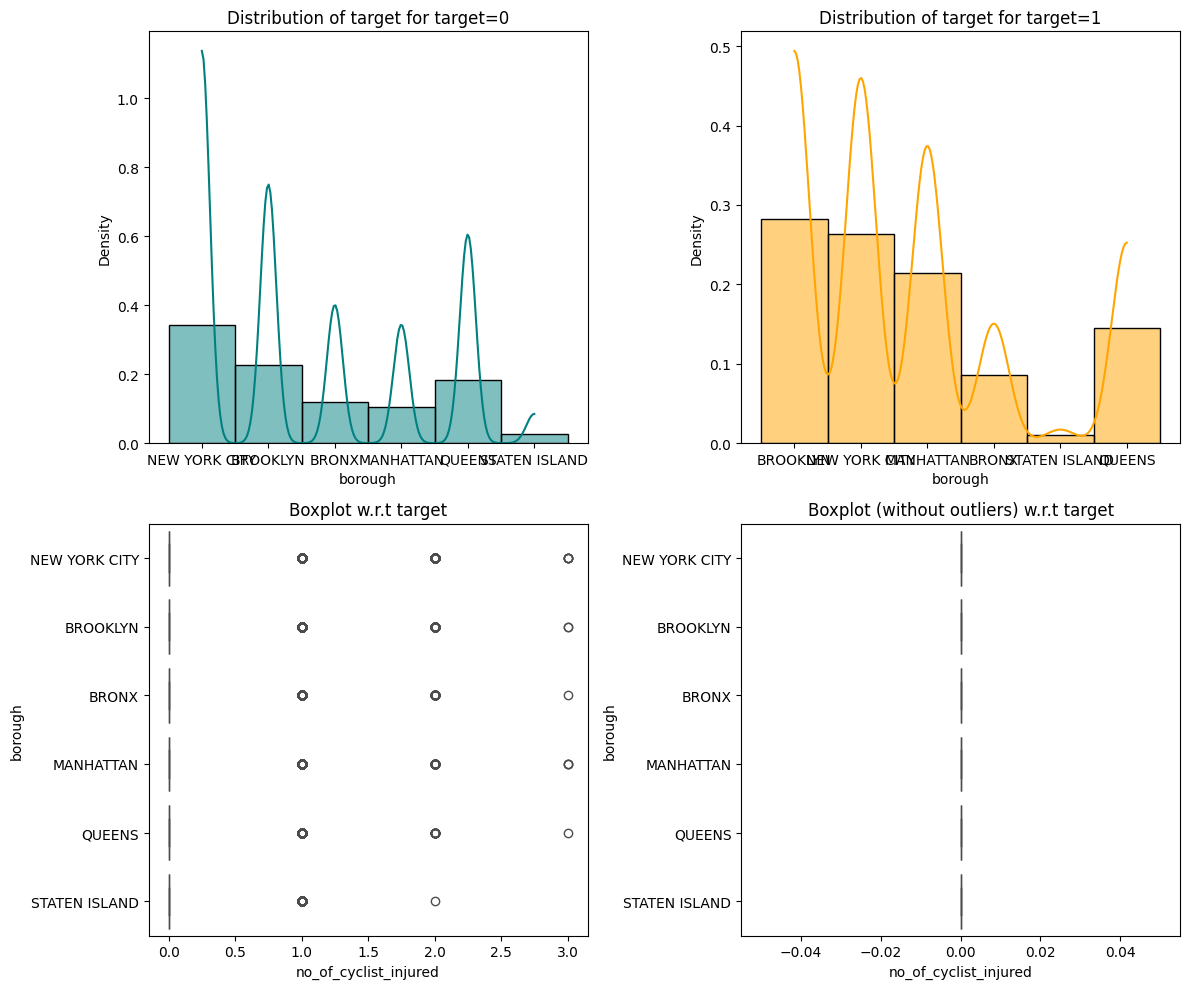

In [49]:
distribution_plot_wrt_target(dataset, "borough", "no_of_cyclist_injured")

In [51]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 423959 entries, 0 to 2129119
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype    
---  ------                      --------------   -----    
 0   crash_date                  423959 non-null  object   
 1   crash_time                  423959 non-null  object   
 2   borough                     423959 non-null  object   
 3   latitude                    423959 non-null  float64  
 4   longitude                   423959 non-null  float64  
 5   on_street_name              423959 non-null  object   
 6   cross_street_name           423959 non-null  object   
 7   no_of_persons_injured       423959 non-null  float64  
 8   no_of_persons_killed        423959 non-null  float64  
 9   no_of_pedestrians_injured   423959 non-null  int64    
 10  no_of_perdestrians_killed   423959 non-null  int64    
 11  no_of_cyclist_injured       423959 non-null  int64    
 12  no_of_cyclist_killed        423959 non-null  int

In [54]:
# Find the most frequent value
most_frequent = dataset['contributing_factor_vech_1'].mode()[0]
# Replace null values with the most frequent value
dataset['contributing_factor_vech_1'].fillna(most_frequent, inplace=True)
most_frequent = dataset['contributing_factor_vech_2'].mode()[0]
# Replace null values with the most frequent value
dataset['contributing_factor_vech_2'].fillna(most_frequent, inplace=True)


most_frequent = dataset['vech_type_code_1'].mode()[0]
# Replace null values with the most frequent value
dataset['vech_type_code_1'].fillna(most_frequent, inplace=True)

# Find the most frequent value
most_frequent = dataset['vech_type_code_2'].mode()[0]
# Replace null values with the most frequent value
dataset['vech_type_code_2'].fillna(most_frequent, inplace=True)



In [55]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 423959 entries, 0 to 2129119
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype    
---  ------                      --------------   -----    
 0   crash_date                  423959 non-null  object   
 1   crash_time                  423959 non-null  object   
 2   borough                     423959 non-null  object   
 3   latitude                    423959 non-null  float64  
 4   longitude                   423959 non-null  float64  
 5   on_street_name              423959 non-null  object   
 6   cross_street_name           423959 non-null  object   
 7   no_of_persons_injured       423959 non-null  float64  
 8   no_of_persons_killed        423959 non-null  float64  
 9   no_of_pedestrians_injured   423959 non-null  int64    
 10  no_of_perdestrians_killed   423959 non-null  int64    
 11  no_of_cyclist_injured       423959 non-null  int64    
 12  no_of_cyclist_killed        423959 non-null  int

In [ ]:
#Checking whether there are still null values in the dataset.
missing = data.isnull().sum()
print(missing)

crash_date                    0
crash_time                    0
borough                       0
latitude                      0
longitude                     0
on_street_name                0
cross_street_name             0
no_of_persons_injured         0
no_of_persons_killed          0
no_of_pedestrians_injured     0
no_of_perdestrians_killed     0
no_of_cyclist_injured         0
no_of_cyclist_killed          0
no_of_motorist_injured        0
no_of_motorist_killed         0
contributing_factor_vech_1    0
contributing_factor_vech_2    0
vech_type_code_1              0
vech_type_code_2              0
dtype: int64


In [ ]:
# for the sake of time, let's work wity a tiny subsample of data
# The dataset had 2130612 rows. This was crashing Colab. In order to complete this excercise I sampled 6000 rows.
dataset = data.sample(6000)